In [2]:
# python >= 3.5
import sys
assert sys.version_info >= (3, 5)

# sklearn >= 0.20
import sklearn
assert sklearn.__version__ >= "0.20"

# tensorflow >= 2.0 
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

IS_COLAB = "google.colab" in sys.modules

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. CNN이 매우 느릴 수 있습니다")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택 후 하드웨어 가속기로 GPU를 고르세요.")
        
import numpy as np
import os
import import_ipynb

np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from initpkg import init_graph, make_image_dir, save_fig

init_graph()
IMAGES_PATH = make_image_dir("cnn")

# CNN

*(핸즈온 머신러닝 책과 혁펜하임의 유튜브 강의를 바탕으로 쓴 내용입니다)*

### 왜 CNN이 필요한가

- overfitting 해결 & 효율성 (속도 향상)

### CNN 이해

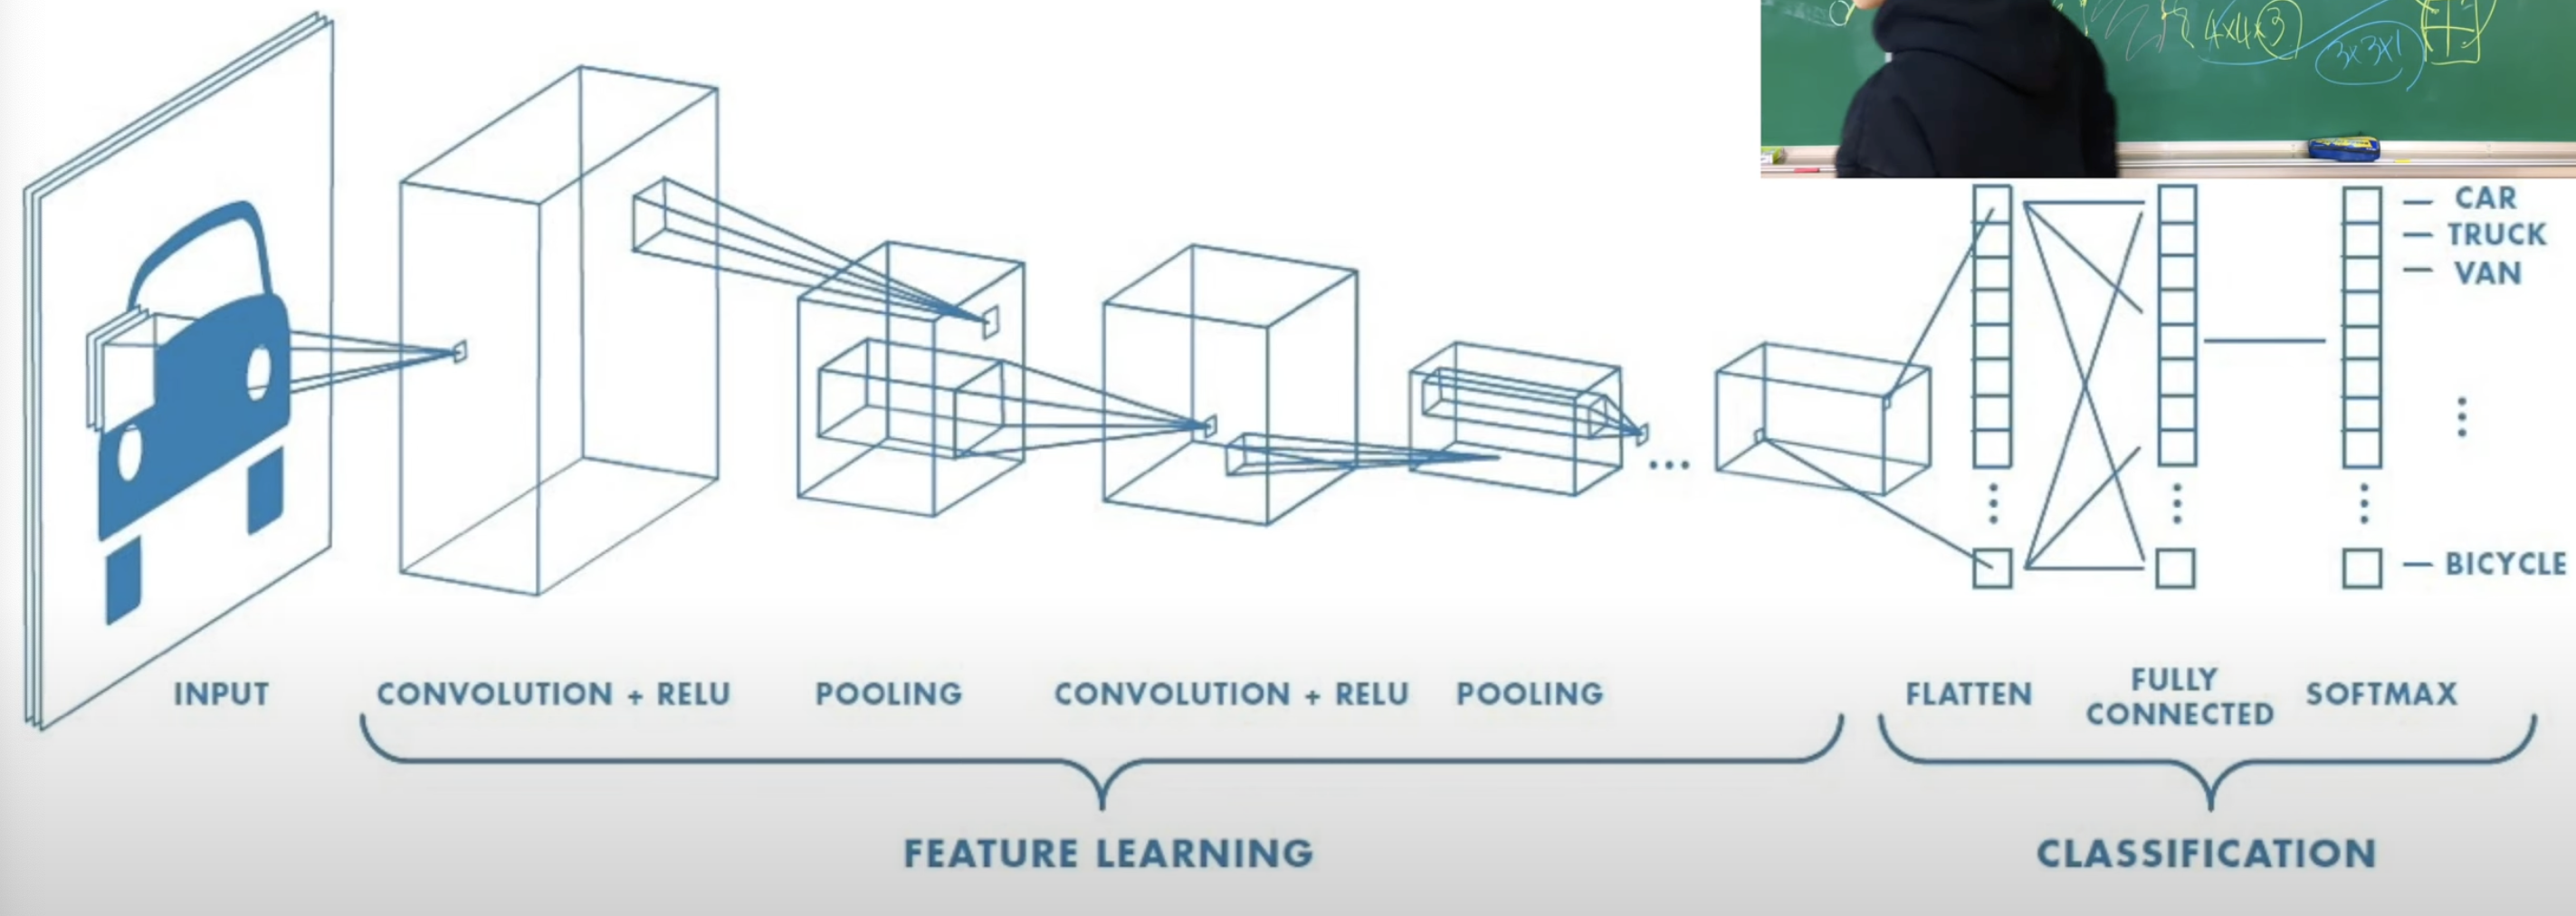

- input은 rgb 3개의 층에 대한 정보로 이루어져있음 (그림이 4x4x3이고, 필터가 2x2x3일 경우 zero padding일 때 3x3x1로 줄어들 것임)
- 필터가 여러개일 수 있음 (필터1은 얼굴을 찾고, 필터2는 코를 찾고 등.. 필터는 머신이 알아서 학습함)
- 필터가 여러개이기 때문에 convolution + relu층의 뉴런이 두껍게 나타나있는 것임
- 필터는 어떻게 훈련하는거지?

### 합성곱 층에 있는 뉴런의 출력 계산

                                                       
$$
z_{i,j,k} = b_k + \sum_{u=0}^{f_{h}-1}\sum_{v=0}^{f_{w}-1}\sum_{k'=0}^{f_{n'}-1} x_{i',j',k'} \times w_{u,v,k',k} 
\; 여기서 \;  
\begin{cases} 
i' = i \times s_h + u \\ 
j' = j \times s_w + v\\ 
\end{cases} 
$$

- 용어 >> 특성 맵 = 필터로 합성곱 한 층, 수용장 = 필터
- 좌변은 합성곱 층의 $k$ 특성 맵에서 $i$행, $j$열에 위치한 뉴런의 출력
- $s_h, s_w$ 은 수직, 수평 스트라이드, $f_h, f_w$ 는 수용장의 높이와 너비, $f_n'$은 이전 층($l$ - 1 층)에 있는 특성 맵의 수
- $w_{u,v,k',k}$ 는

    **$l$ 층의 $k$ 특성 맵(필터)에 있는 모든 뉴런** 과 
    
    **$u$행, $v$열, $k'$특성 맵에 위치한 입력** 
  
  사이의 연결 가중치
- 그림으로 이해하면 쉬움. 필터를 입력에 대해 합성곱하고 (입력에 대한 가중치 합을 계산하고) 편향을 더하는 것임

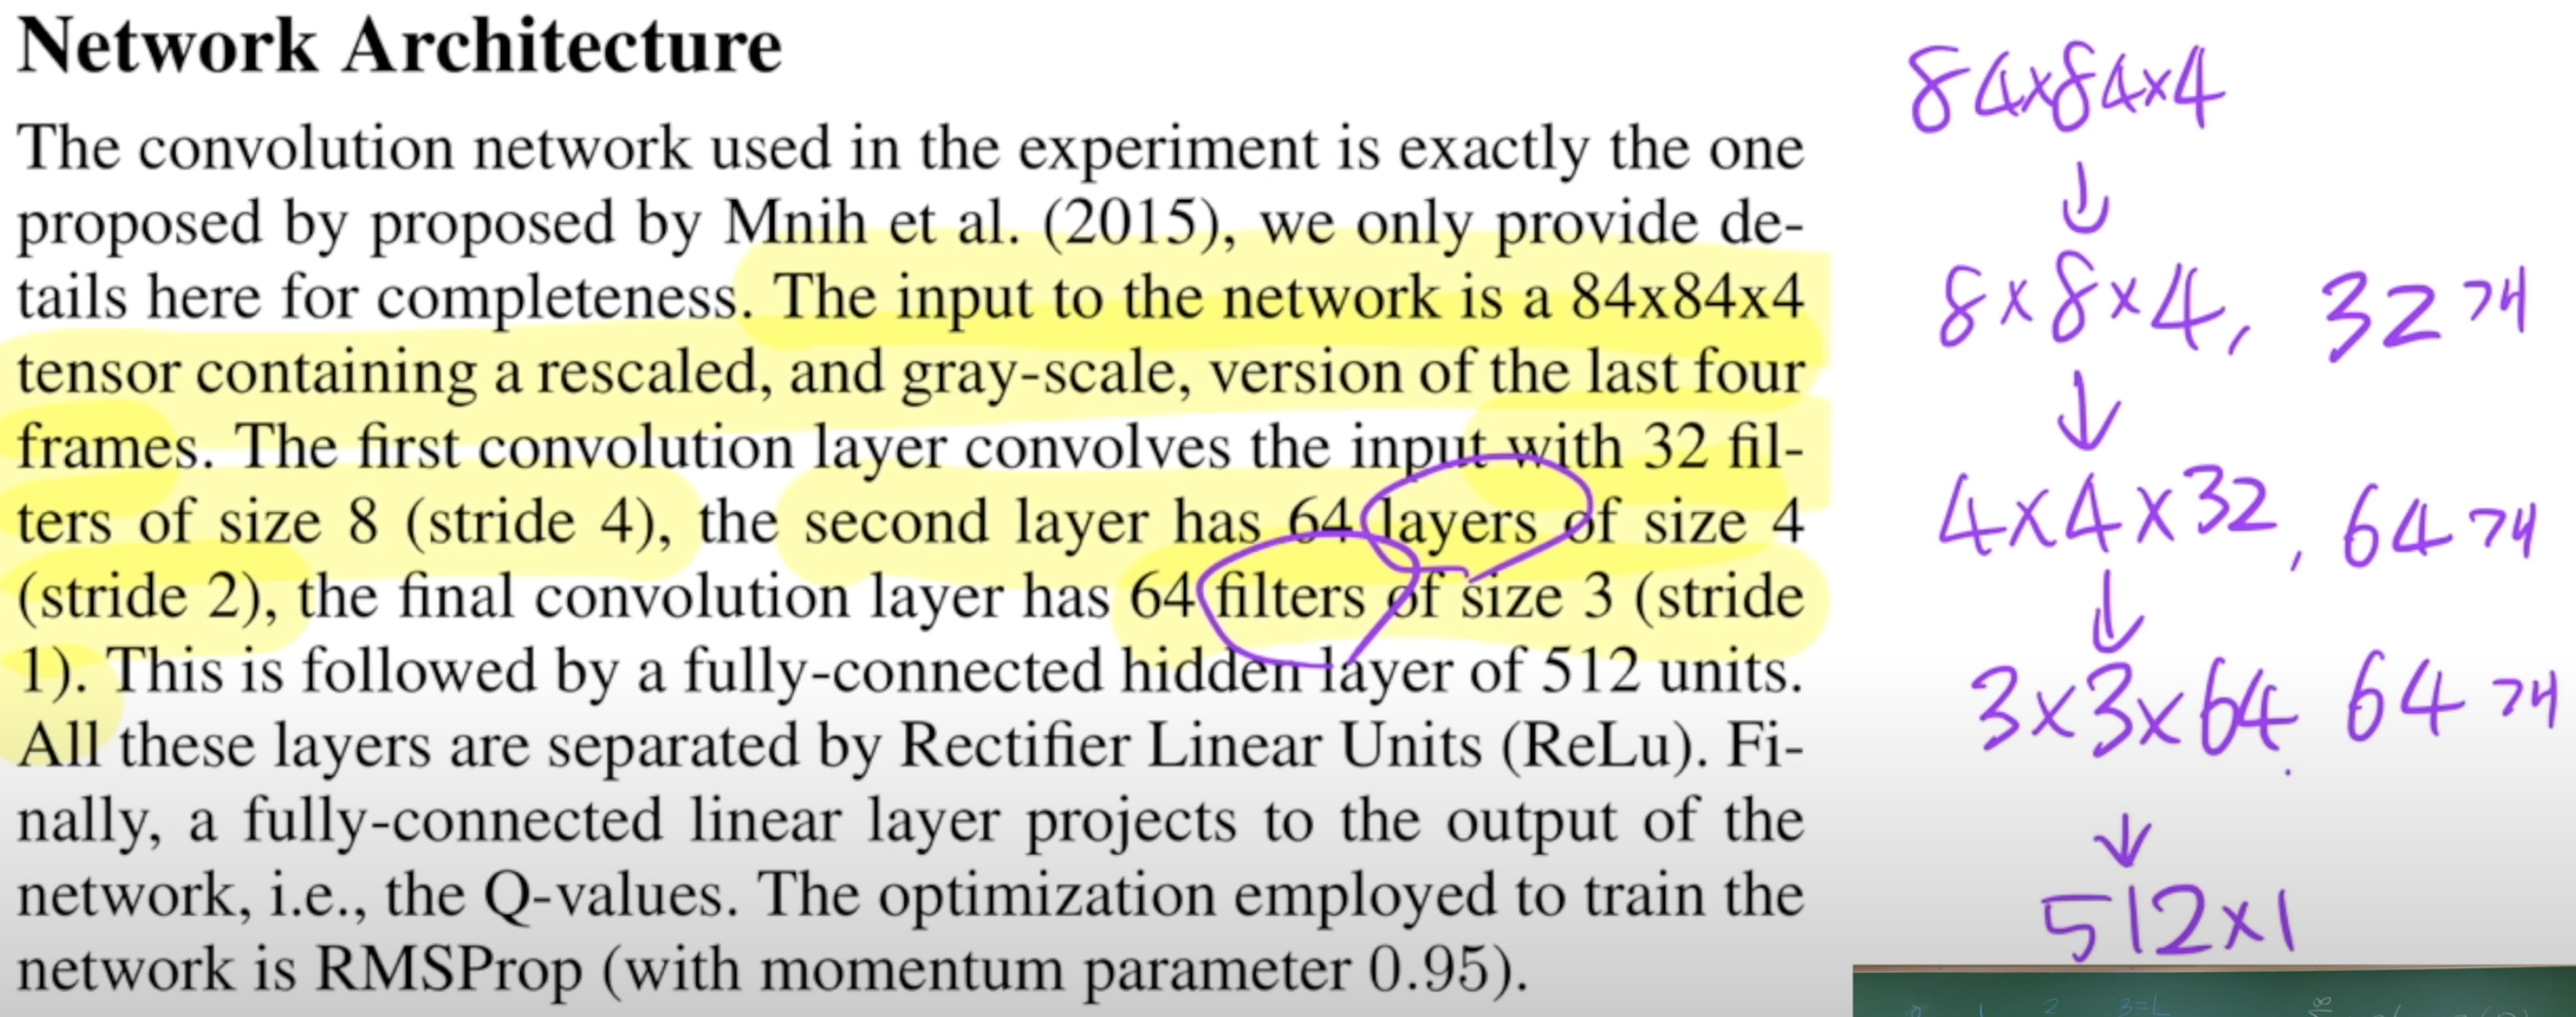

- Input : 84x84x4
- First filter : 8x8x4, 32 (stride 4)
- First convolution layer : ?x?x32
- Second filter : 4x4x32, 64 (stride 2)
- Second convolution layer : ?x?x64
- Final filter : 3x3x64, 64 (stride 1)
- Final convolution layer : ?x?x64  => fully-connected hidden layer of 512

In [3]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")
    
def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

### 텐서플로 구현

- 텐서플로에서 각 입력 이미지는 보통 [높이, 너비, 채널] 형태의 3D 텐서로 표현
- 하나의 미니배치는 [미니배치 크기, 높이, 너비, 채널] 형태의 4D 텐서로 표현
- 합성곱 층의 가중치는 [$f_h, f_w, f_n', f_n$] 형태의 4D 텐서로 표현
- 합성곱 층의 편향은 간단한게 [$f_n$] 형태의 1D 텐서로 표현
- 채널은 그림에서 z축, 깊이, 폭으로 생각하자 
- $f_n'$ 은 이전 층의 특성 맵 수, $f_n$ 은 현재 층의 특성 맵 수 (이전 층이 입력층이면 채널)

In [4]:
from sklearn.datasets import load_sample_image

china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower]) # 여기서 images 는 4D 텐서 (3D 텐서 두개 합침)
batch_size, height, width, channels = images.shape
print("images' shape :", images.shape)

# 둘 다 컬러 이미지 -> channels = 3

# 필터 2개 생성
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
print("filters' shape : ", filters.shape)
filters[:, 3, :, 0] = 1 # 수직선
filters[3, :, :, 1] = 1 # 수평선

images' shape : (2, 427, 640, 3)
filters' shape :  (7, 7, 3, 2)


In [5]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

Metal device set to: Apple M1 Pro


2023-01-31 18:28:16.907904: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-31 18:28:16.908392: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### tf.nn.conv2d()
- 위의 예시에서 images는 입력의 미니배치. 4D 텐서
- filters는 적용될 필터. 4D 텐서
- strides는 1. 4개의 원소를 갖는 1D 텐서로 저장할 수도 있음. 1D 배열의 가운데 두 개의 원소는 수직, 수평 스트라이드. 첫 번째와 마지막 원소는 현재 1이며, 이후 배치 스트라이드(일부 샘플 건너뛰기), 채널 스트라이드(이전 층의 특성 맵이나 채널 건너뛰기)를 지정하는데 사용
- padding은 "VALID" or "SAME" (대문자 필수. 케라스 API에서는 대소문자 구분 x)
  "VALID"는 제로 패딩 사용 x. "SAME"은 제로 패딩 사용

(2, 427, 640, 2)


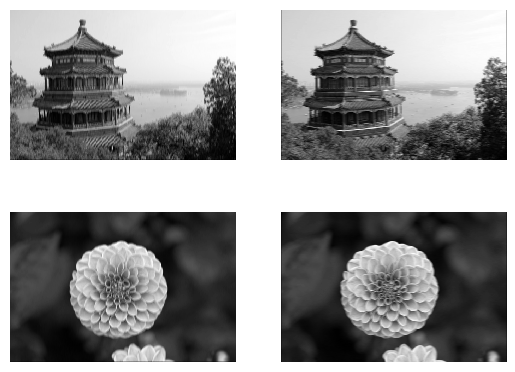

In [61]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

print(outputs.shape) # image_index, height, width, feature_map_index
plt.show()

In [7]:
def crop(images):
    return images[150:220, 130:250]

그림 저장 china_original


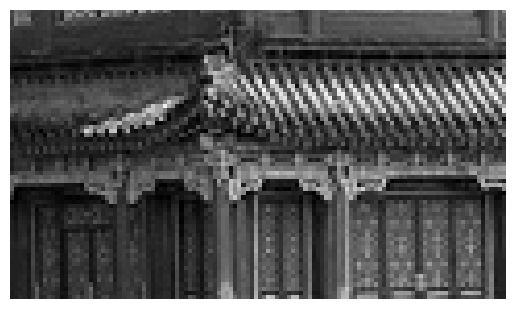

In [8]:
plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", images_path=IMAGES_PATH, tight_layout=False)
plt.show()

그림 저장 china_vertical


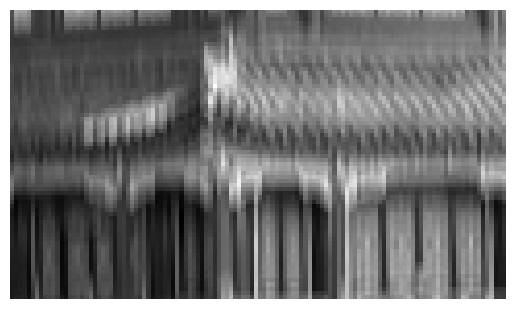

그림 저장 china_horizontal


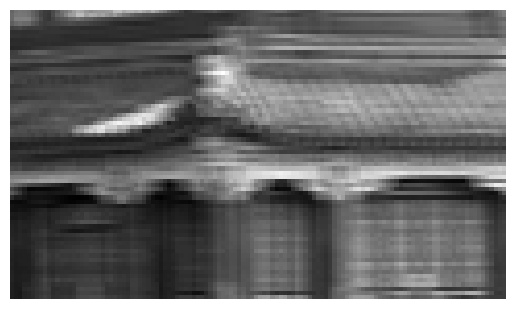

In [9]:
for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, images_path=IMAGES_PATH, tight_layout=False)
    plt.show()

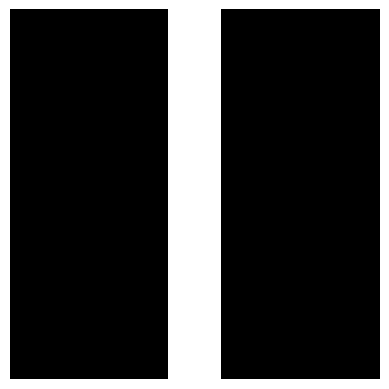

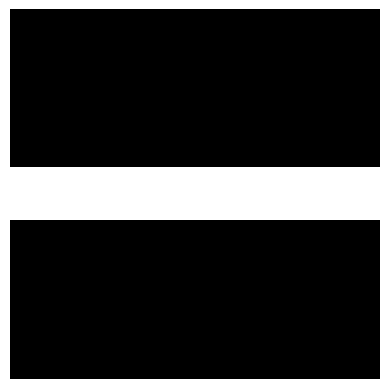

In [14]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

### 합성곱 층

위의 예에서는 필터를 직접 지정했지만 실제 CNN에서는 보통 훈련 가능한 변수로 필터를 정의함

보통 `keras.layers.Conv2d()`를 사용함

- params 중 kernel_size ? -> filter 크기로 생각하자 (7x7)
- [What does kernel size mean?](https://stats.stackexchange.com/questions/296679/what-does-kernel-size-mean)
- conv1d, conv2d, conv3d 차이 ? -> [stackoverflow](https://stackoverflow.com/questions/53164733/difference-between-conv3d-vs-conv2d) 
  
  *Note here that a 2D convolution with (batch, H, W, Channels) is the same as an 3D convolution with (batch, H, W, Channels, 1).*
  
  *2d 그림이 rgb로 3채널을 가진다고 해서 3d 데이터가 되는 것이 아닌듯. 혼동하지 말자*

In [44]:
np.random.seed(42)
tf.random.set_seed(42)

conv = keras.layers.Conv2D(filters=32, kernel_size=7, strides=1,
                           padding="SAME", activation="relu", input_shape=outputs.shape)

In [45]:
conv_outputs = conv(images)
print("images' shape :", images.shape)
print("outputs' shape :", conv_outputs.shape)

images' shape : (2, 427, 640, 3)
outputs' shape : (2, 427, 640, 32)


출력은 4D 텐서. (배치 크기, 높이, 너비, 채널)

2개의 이미지를 입력했기 때문에 배치 크기는 2. `padding="SAME`, `strides=1`로 설정했기 때문에 출력 특성맵의 높이와 너비는 입력과 동일 (427 X 640). 32개의 필터를 사용했기 때문에 마지막 차원의 크기는 32.

필터는 초기에 랜덤하게 초기화되기 때문에 처음에 랜덤한 패턴을 감지함.

이미지마다 출력된 두 번째 특성맵까지만 확인해보자.

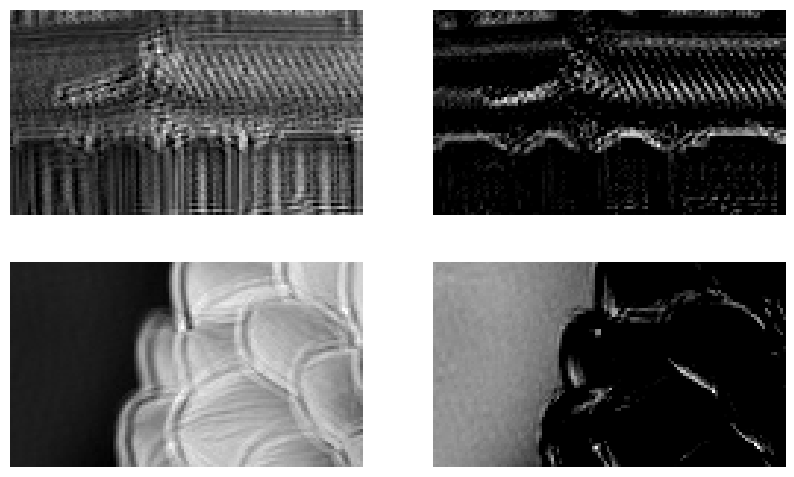

In [46]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

필터가 랜덤하게 초기화되었는데 두 번째 필터는 경계선(edge)을 감지한 것 같음. 에지 감지는 이미지 처리에 유용함.

앞에서 수동으로 정의한 필터를 사용하고 편향을 0으로 지정해줄 수 있음(합성곱 층이 훈련하는 동안 필터와 편향을 학습하기 때문에 실제로 지정할 필요는 거의 없음)
 * 지정해주기 전에 한번 `conv(images)` 로 가중치를 초기화 해주어야 하는 듯. 안그러면 오류남

In [57]:
conv = keras.layers.Conv2D(filters=2, kernel_size=7, strides=1,
                           padding="SAME", activation="relu", input_shape=outputs.shape)
conv(images)
conv.set_weights([filters, np.zeros(2)])

In [58]:
conv_outputs = conv(images)
conv_outputs.shape

TensorShape([2, 427, 640, 2])

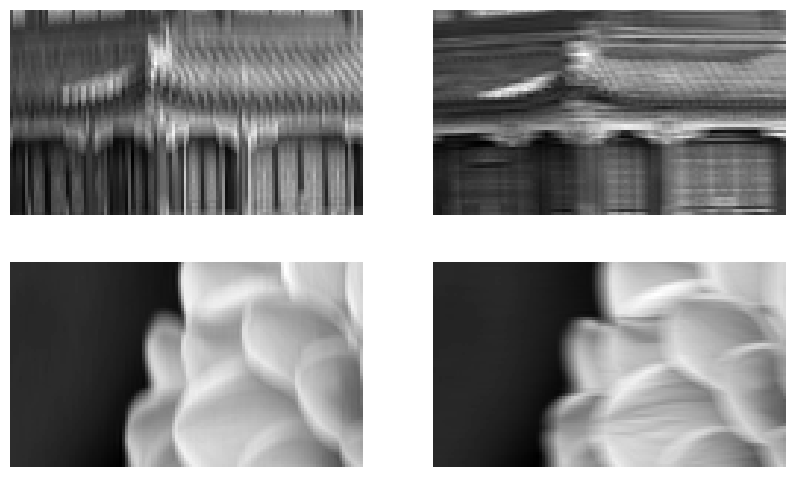

In [62]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

### VALID vs SAME

In [72]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1

In [73]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

In [78]:
def manual_same_padding(images, kernel_size, strides = 1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width = pad_before_and_padded_size(width, kernel_size, strides)
    print(top_pad, padded_height)
    print(left_pad, padded_width)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    print(padded_images.shape)
    return padded_images

`"SAME"`패딩을 사용하는 것은 `manual_same_padding()`을 사용해 수동으로 패딩하고 `"VALID"`패딩을 사용하는 것과 동일함 (`"VALID"`패딩은 전혀 패딩하지 않는다는 뜻)

In [79]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# conv_samed의 가중치 생성 위해 build() 메서드 호출
conv_same.build(tf.TensorShape(images.shape))

# conv_valid의 가중치를 conv_same으로 복사
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

# np.allclose() 를 이용해 두 배열이 모든 요소가 같은 지 확인
assert np.allclose(valid_output.numpy(), same_output.numpy())

print(images.shape)

3 433
2 645
(2, 433, 645, 3)
(2, 427, 640, 3)


- `strides=2` 일 때 패딩하면 427 x 640 에서 433 x 645가 되는 듯
- `feature_map_size()` 와 `pad_before_and_padded_size()`가 어떤 용도인지 이해가 안감